In [56]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
%%bigquery df
SELECT
*
FROM `openloot-362008.postgres_rds_public.orders` a

left join openloot-362008.postgres_rds_public.items b on a.item_id=b.id
left join openloot-362008.postgres_rds_public.items_metadata c on b.option_name=c.option_name
where a.created_at > '2025-11-01'

Query is running:   0%|          |

Downloading:   0%|          |

In [57]:
# filter out non-Big Time items
bt = df[df['collection']=='BT0']

# limit to the appropriate collection
bt_xmas = bt.loc[
    bt['option_name'].str.contains('christmas',case=False,na=False) &
    bt['option_name'].str.contains('2025',case=False, na=False)
]

# date transformations
bt_xmas['created_at'] = pd.to_datetime(bt_xmas['created_at'])
bt_xmas['date'] = bt_xmas['created_at'].dt.date

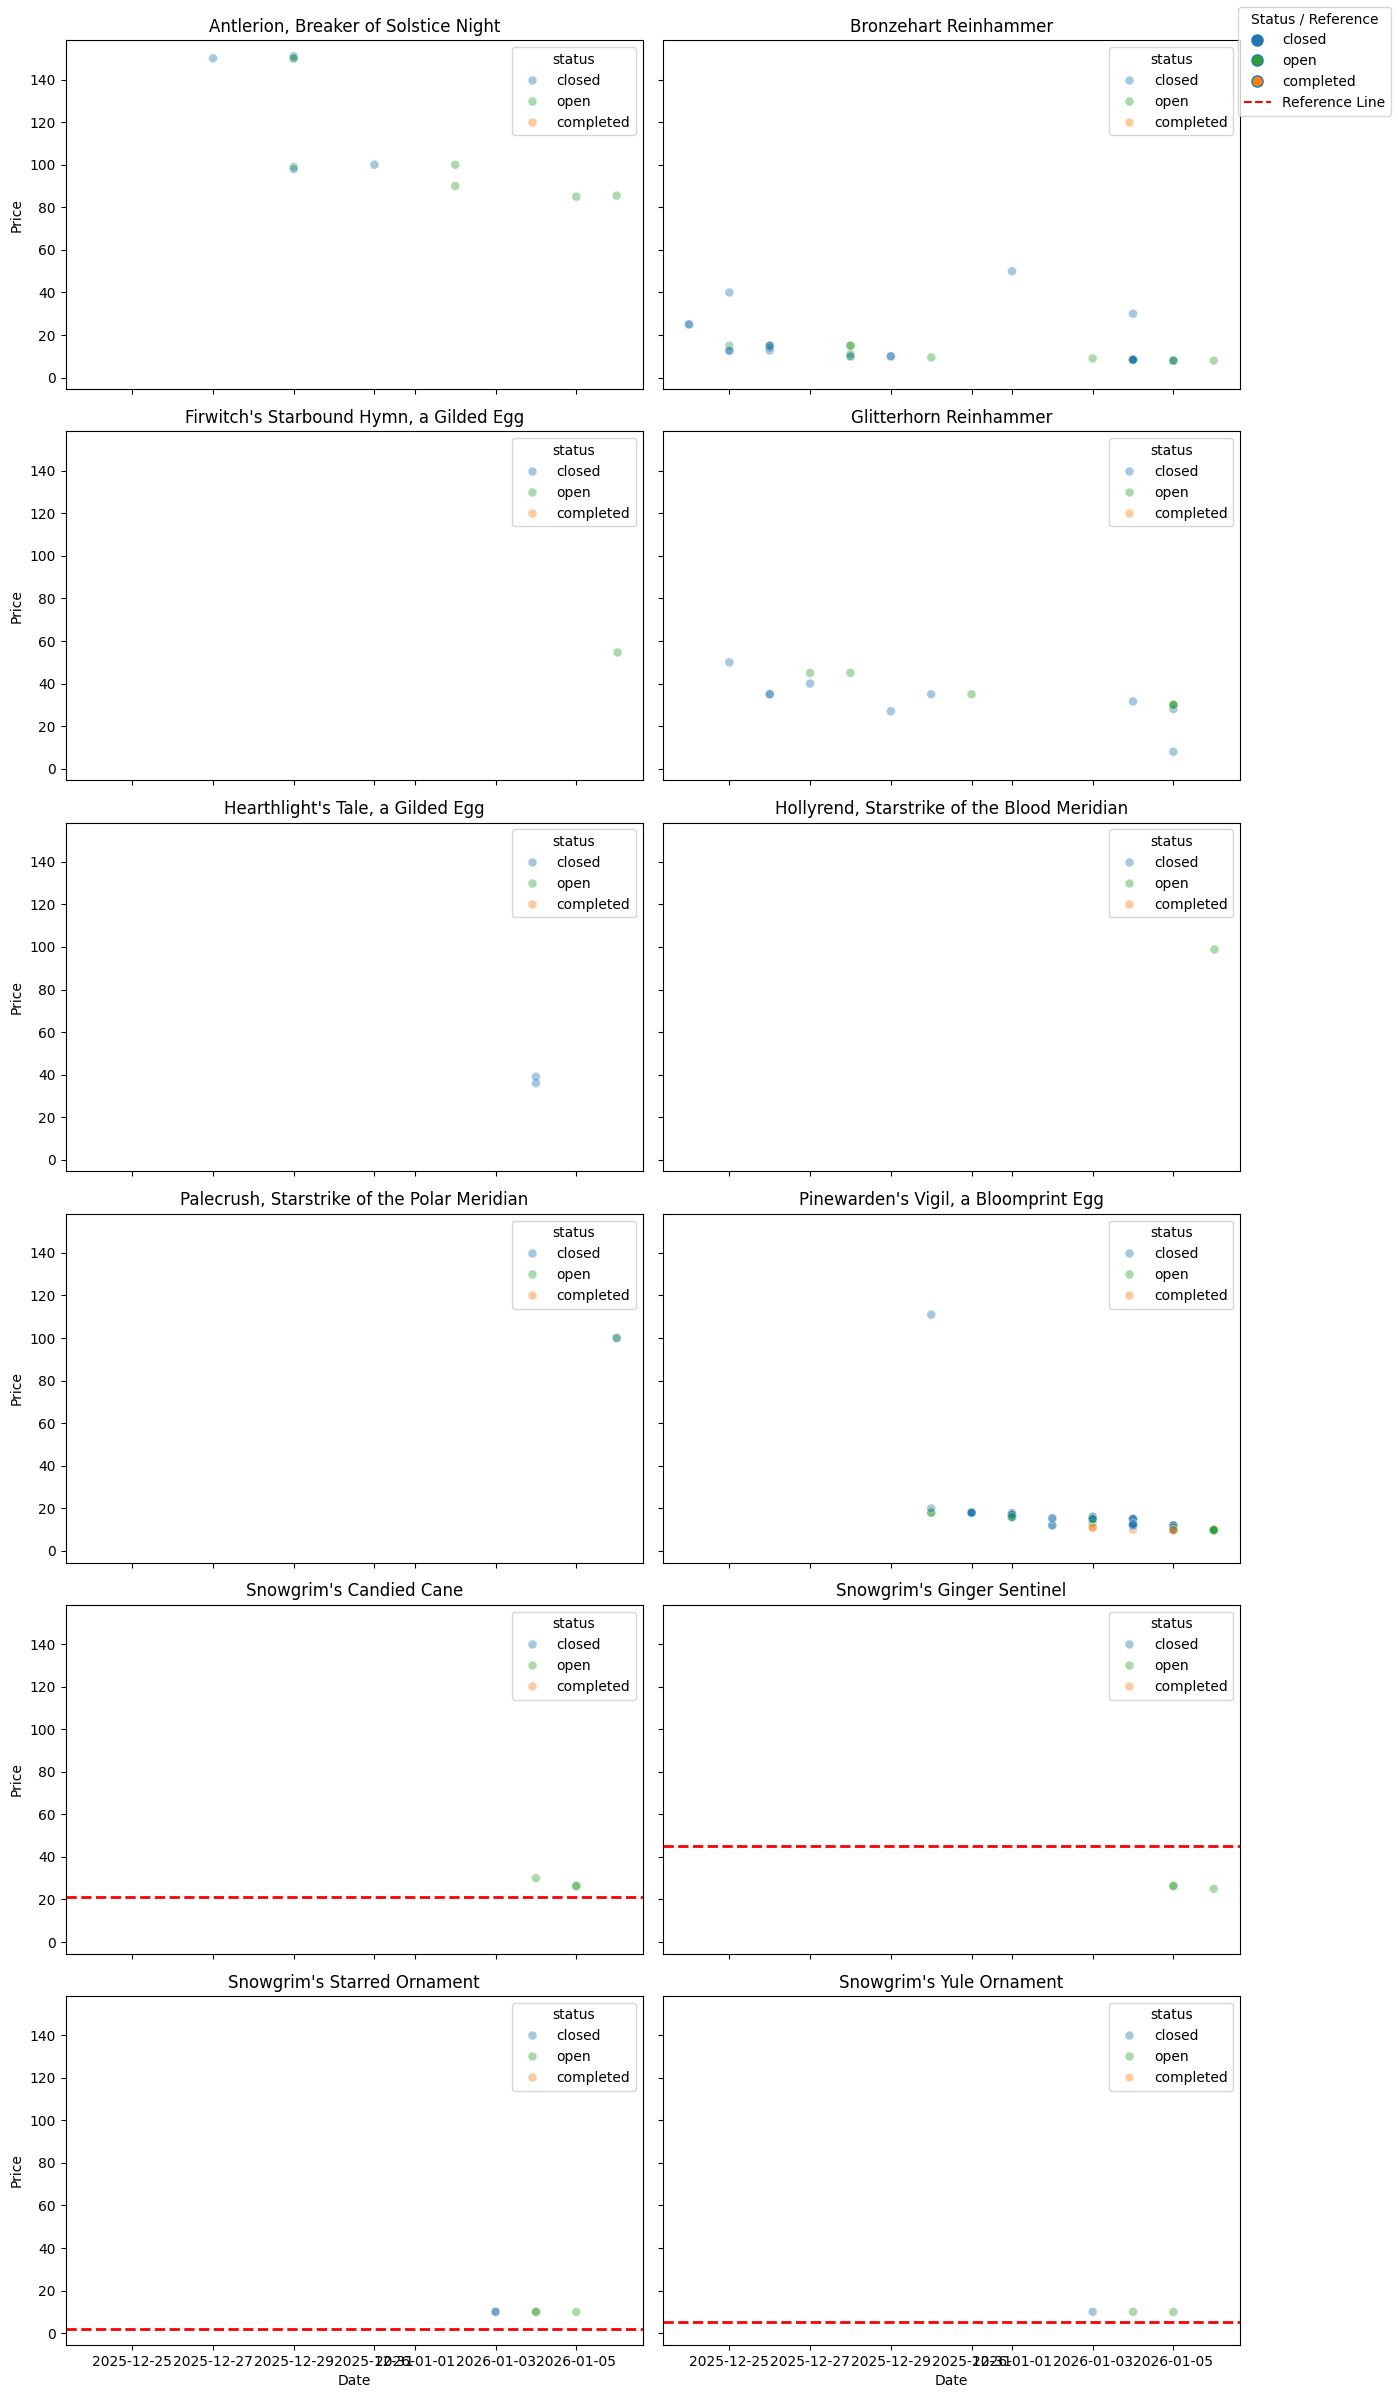

In [55]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# set reference lines for the cost basis
hline_values = {
    "Snowgrim's Starred Ornament": 2,
    "Snowgrim's Yule Ornament": 5,
    "Snowgrim's Candied Cane": 21,
    "Snowgrim's Ginger Sentinel": 45
}

item_names = bt_xmas['name'].unique()
n_items = len(item_names)
n_cols = 2
n_rows = math.ceil(n_items / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(14, 4 * n_rows),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

ALL_STATUSES = ['closed', 'open', 'completed']

palette = {
    'closed': '#1f77b4',
    'open': '#2ca02c',
    'completed': '#ff7f0e'
}

for ax, (option_name, sub) in zip(axes, bt_xmas.groupby('name')):
    # base graph
    sns.scatterplot(
        x='date',
        y='price',
        hue='status',
        hue_order=ALL_STATUSES,
        palette=palette,
        alpha=0.4,
        s=40,
        data=sub,
        ax=ax
    )

    ax.set_title(option_name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # refernce lines
    if option_name in hline_values:
        ax.axhline(
            y=hline_values[option_name],
            color='red',
            linestyle='--',
            linewidth=2,
            label='Reference Line'
        )

# remove empty plots if any
for ax in axes[len(item_names):]:
    ax.remove()

# one global legend for statuses + reference line
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='', label=status,
           markerfacecolor=palette[status], markersize=8)
    for status in ALL_STATUSES
]

# Add reference line to legend
legend_elements.append(Line2D([0], [0], color='red', linestyle='--', label='Reference Line'))

fig.legend(handles=legend_elements, title='Status / Reference', loc='upper right')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()